<a href="https://colab.research.google.com/github/jinyoungkim0214/materials-classification/blob/main/materialsclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import하기

In [ ]:
# apache 2.0

In [ ]:
import os
import os.path
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
from google.colab import drive  # 구글 드라이브 마운트용

import matplotlib.pyplot as plt
import numpy as np

# 이미지 class 47개
# 구글 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# DATASET_PATH
#├── images/
#│   ├── bark/
#│   ├── cable/
#│   └── ...
#└── labels/
#    ├── train1.txt
#   ├── val1.txt
#   └── test1.txt

#images/ 폴더 내의 directory 모두 읽고 정렬해서 class 이름&class to index 맵 만들기
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

#txt 파일 목록 받아서 리스트 안의 이미지 경로랑 label
def make_dataset(txtnames, datadir, class_to_idx):
    images = []
    labels = []
    for txtname in txtnames:
        with open(txtname, 'r') as lines:
            for line in lines:
                classname = line.split('/')[0]
                _img = os.path.join(datadir, 'images', line.strip())
                assert os.path.isfile(_img)
                images.append(_img)
                labels.append(class_to_idx[classname])

    return images, labels

#이미지랑 label이 각각 저장이 됨
#경로랑 label을 이미지랑 label에 저장 (용량을 줄이고 싶어서, 이미지는 경로만, label은 텍스트니까 그대로 해도 괜찮다)
class DTDDataloader(data.Dataset):
    def __init__(self, DATASET_PATH, split, transform=None, train=True):
        classes, class_to_idx = find_classes(os.path.join(DATASET_PATH, 'images'))
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.train = train
        self.transform = transform

        if train:
            filename = [os.path.join(DATASET_PATH, 'labels/train' + split + '.txt'),
                        os.path.join(DATASET_PATH, 'labels/val' + split + '.txt')]
        else:
            filename = [os.path.join(DATASET_PATH, 'labels/test' + split + '.txt')]

        self.images, self.labels = make_dataset(filename, DATASET_PATH, class_to_idx)
        assert (len(self.images) == len(self.labels))

    def __getitem__(self, index):#이미지의 인덱스가 0~ 이미지 경로 오픈해서 rgb로 변환
        _img = Image.open(self.images[index]).convert('RGB') #여기에rgb저장
        _label = self.labels[index]
        if self.transform is not None:
            _img = self.transform(_img)

        return _img, _label

    def __len__(self):
        return len(self.images)


class Dataloader():
    def __init__(self, DATASET_PATH, split, batch_size):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]) #정규화
        transform_train = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            normalize,
        ]) #trainsform train 부분에 augmentation 기법 여러 가지 적용해봐도 좋을 듯?
        transform_test = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            #transforms.Resize(64),
            #transforms.CenterCrop(32),
            transforms.ToTensor(),
            normalize,
        ])
#train이랑 test DTDDataloader 만들고, torch Dataloader로 래핑해줌
#trainsform_train이랑 transform_test 구분해서 적용해주기
        trainset = DTDDataloader(DATASET_PATH, split, transform_train, train=True)
        testset = DTDDataloader(DATASET_PATH, split, transform_test, train=False)

        kwargs = {'num_workers': 8, 'pin_memory': True}
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=
        256, shuffle=True, **kwargs)
        testloader = torch.utils.data.DataLoader(testset, batch_size=
        256, shuffle=False, **kwargs)
        self.classes = trainset.classes
        self.trainloader = trainloader
        self.testloader = testloader

    def getloader(self): #tensor로 바꿔주고 학습시키기 #클래스 목록이랑 로더 반환시킴
        return self.classes, self.trainloader, self.testloader

전처리(pre-processing)
* 학습 data, train, validation, test를 어떻게 나눌 건지 (데이터 6:2:2를 어떻게 나눌 건지?) - 총 수천~수만 장은 필요함

dataset 불러오기

In [ ]:
#%cd /content/drive/MyDrive
#!unzip "dataset.zip"

In [ ]:
# 데이터셋 경로 설정 (구글 드라이브 내 dataset/dtd 폴더)
DATASET_PATH = '/content/drive/MyDrive/dataset1/dtd'
split = '1'
batch_size = 256

In [ ]:
#배치 사이즈 32, split=1로 데이터로더 생성
dataloader = Dataloder(DATASET_PATH, batch_size=256, split='1')
classes, trainloader, testloader = dataloader.getloader()

# 데이터로더 테스트
for images, labels in trainloader:
    print(images.shape, labels.shape)
    break

torch.Size([256, 3, 224, 224]) torch.Size([256])


network 설계
* 어떤 network를 사용할 건지
* 차원 계산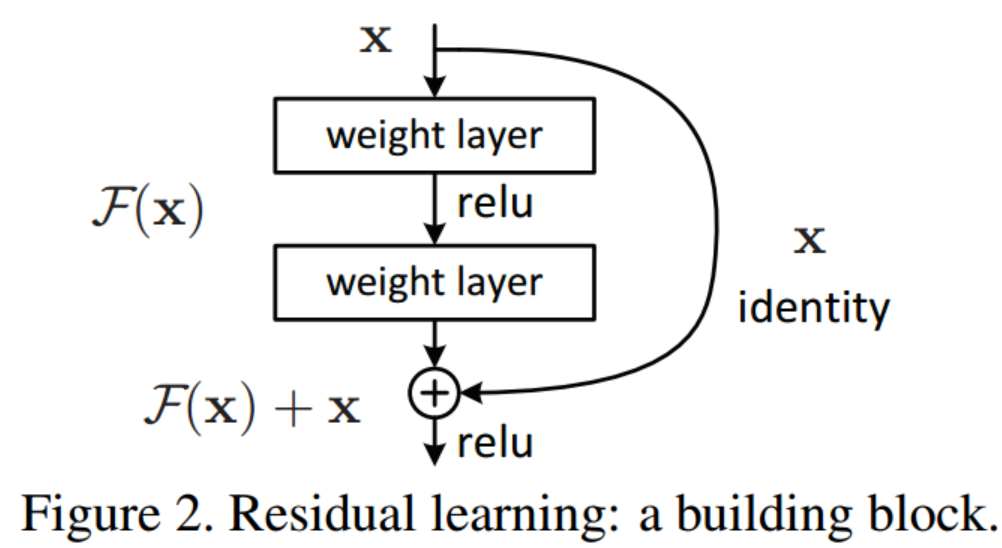

In [ ]:
import torch
import torch.nn as nn
from typing import Dict, List, Tuple, Union

#여기서부터 BasicBlock (ConV 3개: 1*1 -> 3*3 -> 1*1)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes: int, out_planes: int, stride: int = 1, downsample: nn.Module = None,
                 padding_mode: str = 'constant'):
        super().__init__()
        self.conv1 = self._make_conv(in_planes, out_planes, kernel_size=3, stride=stride,
                                     padding=1, padding_mode=padding_mode)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = self._make_conv(out_planes, out_planes, kernel_size=3, stride=1,
                                     padding=1, padding_mode=padding_mode)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def _make_conv(self, in_ch, out_ch, kernel_size, stride, padding, padding_mode):
        conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride,
                         padding=padding, bias=False)
        return conv

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

#여기서부터 Bottleneck (ConV 2개: 3*3 -> 3*3)
class Bottleneck(nn.Module): #conv여러개 -> bottleneck 한 덩어리 -> 여러개 -> Resnet
    expansion = 4
    def __init__(self, in_planes: int, out_planes: int, stride: int = 1, downsample: nn.Module = None,
                 padding_mode: str = 'constant'):
        super().__init__()
        mid_planes = out_planes
        self.conv1 = self._make_conv(in_planes, mid_planes, kernel_size=1, stride=1,
                                     padding=0, padding_mode=padding_mode)
        self.bn1 = nn.BatchNorm2d(mid_planes)
        self.conv2 = self._make_conv(mid_planes, mid_planes, kernel_size=3, stride=stride,
                                     padding=1, padding_mode=padding_mode)
        self.bn2 = nn.BatchNorm2d(mid_planes)
        self.conv3 = self._make_conv(mid_planes, out_planes * self.expansion, kernel_size=1, stride=1,
                                     padding=0, padding_mode=padding_mode)
        self.bn3 = nn.BatchNorm2d(out_planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def _make_conv(self, in_ch, out_ch, kernel_size, stride, padding, padding_mode):
        conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride,
                         padding=padding, bias=False)
        return conv

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

resnet_cfgs: Dict[str, Tuple[Union[BasicBlock, Bottleneck], List[int]]] = {
    "resnet18":  (BasicBlock,  [2, 2, 2, 2]), #bottleneck보다 가벼운게 basicblock
    "resnet34":  (BasicBlock,  [3, 4, 6, 3]), #(3+4+6+3)*2+1+1 (맨 마지막 부분 2개)

    "resnet50":  (Bottleneck, [3, 4, 6, 3]), #여기서는 34로 돌림
    "resnet101":  (Bottleneck, [3, 4, 23, 3]), #(3+4+23+3)*3+1+1=101
    "resnet152":  (Bottleneck, [3, 8, 36, 3]) #(3+8+36+3)*3+1+1=152
    }


# 크게 봤을 때
#Conv7x7(stride=2) → BN → ReLU → MaxPool
#→ Layer1 (stride=1)
#→ Layer2 (stride=2)
#→ Layer3 (stride=2)
#→ Layer4 (stride=2)

def make_resnet_layers(
    resnet_type: str = "resnet18",
    in_channels: int = 1,
    padding_mode: str = "constant"
) -> nn.Module:
    block_class, layer_cfg = resnet_cfgs[resnet_type]

    class ResNetLayers(nn.Module):
        def __init__(self):
            super().__init__()
            # Initial conv7x7 + BN + ReLU + MaxPool
            self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            self.relu = nn.ReLU(inplace=True)
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            # Define layers
            self.layer1 = self._make_layer(block_class, 64, 64, layer_cfg[0], stride=1, padding_mode=padding_mode)
            self.layer2 = self._make_layer(block_class, 64 * block_class.expansion, 128, layer_cfg[1], stride=2, padding_mode=padding_mode)
            self.layer3 = self._make_layer(block_class, 128 * block_class.expansion, 256, layer_cfg[2], stride=2, padding_mode=padding_mode)
            self.layer4 = self._make_layer(block_class, 256 * block_class.expansion, 512, layer_cfg[3], stride=2, padding_mode=padding_mode)

        def _make_layer(self, block, in_ch, out_ch, num_blocks, stride, padding_mode):
            downsample = None
            if stride != 1 or in_ch != out_ch * block.expansion:
                downsample = nn.Sequential(
                    nn.Conv2d(in_ch, out_ch * block.expansion, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_ch * block.expansion),
                )
            blocks = []
            blocks.append(block(in_ch, out_ch, stride=stride, downsample=downsample, padding_mode=padding_mode))
            in_ch = out_ch * block.expansion
            for _ in range(1, num_blocks):
                blocks.append(block(in_ch, out_ch, stride=1, downsample=None, padding_mode=padding_mode))
            return nn.Sequential(*blocks)

        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)
            out1 = self.layer1(x)
            out2 = self.layer2(out1)
            out3 = self.layer3(out2)
            out4 = self.layer4(out3)
            return out4

    return ResNetLayers()

class ResNetFeatureExtractor(nn.Module):
    def __init__(
        self,
        resnet_type: str = "resnet18",
        in_channels: int = 3,
        padding_mode: str = 'constant'
    ):
        super().__init__()
        assert resnet_type in resnet_cfgs, f"Unsupported ResNet type: {resnet_type}"

        self.resnet_type = resnet_type
        self.in_channels = in_channels
        self.padding_mode = padding_mode
        self.feature_extractor = make_resnet_layers(resnet_type, in_channels, padding_mode)
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        return self.feature_extractor(x)

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [ ]:
class BaselineModel1(nn.Module):
    def __init__(self):
        super().__init__()
        #self.fe = ResNetFeatureExtractor(resnet_type="resnet152", in_channels=3) #resnetfeatureextractor: backbone부분
        self.fe = ResNetFeatureExtractor(resnet_type="resnet101", in_channels=3)
        #self.fe = ResNetFeatureExtractor(resnet_type="resnet50", in_channels=3)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 47) #데이터셋에 맞게 수정하기 (클래스 47개)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fe(x)
        #여기서부터 head
        x = self.avgpool(x)
        print('avgpool shape:', x.shape)
        x = torch.flatten(x, 1)
        print('flatten shape:', x.shape)
        x = self.fc(x)
        print('fc shape:', x.shape)

        return x

net=BaselineModel1()

parameter 정의
* 어떤 loss를 쓸 건지
* 어떤 optimizer를 쓸 건지
* 학습률은 몇으로 할 건지
* 몇 epoch을 학습시킬 건지

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)  # Learning rate: 학습률. 한 번의 optimizer step에서 얼마나 멀리 갈지.


      """Train Config"""
      C.lr = 1e-2
      C.lr_decay = 40
      C.momentum = 0.9
      C.weight_decay = 1e-4
      C.batch_size = 64
      C.start_epoch = 1
      C.nepochs = 100
      C.eval = False
      C.split = '1'

      C.cuda = True
      C.gpu = '0'
      C.resume = False
      C.momentum = 0.9
      C.weight_decay = 1e-4

train(학습)

In [ ]:
training_loss_history = []
test_loss_history = []

In [ ]:
# class Dataloder():
#     def __init__(self, DATASET_PATH, split, batch_size):
#         normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                          std=[0.229, 0.224, 0.225])

#         # --- 학습용(증강 그대로) ---
#         transform_train = transforms.Compose([
#             transforms.Resize(256),
#             transforms.RandomResizedCrop(224),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip(),
#             transforms.ToTensor(),
#             normalize,
#         ])

#         # --- 🔴 여기 수정: 테스트·검증용도 224×224로 고정 🔴 ---
#         transform_test = transforms.Compose([
#             transforms.Resize(256),       # 긴 변 기준 256
#             transforms.CenterCrop(224),   # 가운데서 224×224 잘라내기
#             transforms.ToTensor(),
#             normalize,
#         ])
#         # -------------------------------------------------------

#         trainset = DTDDataloader(DATASET_PATH, split, transform_train, train=True)
#         testset  = DTDDataloader(DATASET_PATH, split, transform_test,  train=False)

#         kwargs = {'num_workers': 8, 'pin_memory': True}
#         trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                                   shuffle=True,  **kwargs)
#         testloader  = torch.utils.data.DataLoader(testset,  batch_size=256,
#                                                   shuffle=False, **kwargs)

#         self.classes     = trainset.classes
#         self.trainloader = trainloader
#         self.testloader  = testloader


In [ ]:
for epoch in range(2):  # 전체 데이터셋을 몇 번 반복할 건지

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # trainloader로부터 데이터와 라벨을 받아옵니다.
        inputs, labels = data

        # 매 반복마다 이전 gradient를 한 번 지워줍니다.
        optimizer.zero_grad()

        # 모델에 데이터 넣어서 forward 해주고
        # backprop으로 이번 input에 대해 gradient를 계산해주고
        # optimizer가 gradient descent 1스텝 진행
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 결과치 화면에 뿌려주기
        running_loss += loss.item()
        if i % 10 == 9:    # 200 미니배치마다 출력 i=0~199: 200개가 통과; 200개마다 프린트해서 보자 #역전파하고 있으니까 학습데이터에 대한 loss는 계속 줄어듦
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))

            # 나중에 시각화를 위해 중간중간 따로 loss값 저장
            training_loss_history.append(running_loss / 200)

            with torch.no_grad():
                running_test_loss = 0.0
                for i, test_data in enumerate(testloader, 0):
                    test_images, test_labels = test_data
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs, test_labels)
                    running_test_loss += test_loss.item()

                test_loss_history.append(running_test_loss / i)

            running_loss = 0.0

print('학습 끝!')

avgpool shape: torch.Size([256, 2048, 1, 1])
flatten shape: torch.Size([256, 2048])
fc shape: torch.Size([256, 47])
avgpool shape: torch.Size([256, 2048, 1, 1])
flatten shape: torch.Size([256, 2048])
fc shape: torch.Size([256, 47])
avgpool shape: torch.Size([256, 2048, 1, 1])
flatten shape: torch.Size([256, 2048])
fc shape: torch.Size([256, 47])
avgpool shape: torch.Size([256, 2048, 1, 1])
flatten shape: torch.Size([256, 2048])
fc shape: torch.Size([256, 47])
avgpool shape: torch.Size([256, 2048, 1, 1])
flatten shape: torch.Size([256, 2048])
fc shape: torch.Size([256, 47])
avgpool shape: torch.Size([256, 2048, 1, 1])
flatten shape: torch.Size([256, 2048])
fc shape: torch.Size([256, 47])
avgpool shape: torch.Size([256, 2048, 1, 1])
flatten shape: torch.Size([256, 2048])
fc shape: torch.Size([256, 47])
avgpool shape: torch.Size([256, 2048, 1, 1])
flatten shape: torch.Size([256, 2048])
fc shape: torch.Size([256, 47])
avgpool shape: torch.Size([256, 2048, 1, 1])
flatten shape: torch.Size([

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 211, in collate
    return [
           ^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [3, 64, 64] at entry 0 and [3, 64, 81] at entry 1


test

In [ ]:
plt.plot(training_loss_history, label="Training Loss")
plt.plot(test_loss_history, 'r', label="Test Loss")
plt.title('Training & Test Loss', fontsize=20)
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.show()

In [ ]:
PATH = './dtd_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
classes, train_loader, test_loader = Dataloder(DATASET_PATH, batch_size, split).getloader()

dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)
outputs

In [ ]:
_, predicted = torch.max(outputs, 1)  # 1번째 차원(=각 row)에서 각각 max인 값과 해당 index를 뽑아오기
print('모델 예측: ', ', '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# 원래 이미지랑 같이 보기
imshow(torchvision.utils.make_grid(images[:4]))
print('실제 정답: ', ', '.join('%5s' % classes[labels[j]] for j in range(4)))
print('모델 예측: ', ', '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('10000개의 테스트 이미지에 대한 정답률: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(47))
class_total = list(0. for i in range(47))

with torch.no_grad():  # 매우매우 중요!  테스트셋으로 backprop을 하면 안 됨.
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(47):
    print('%5s 클래스의 정답률 : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터 로더 준비
classes, train_loader, test_loader = Dataloader(DATASET_PATH, batch_size, split).getloader()

# 모델 선언 및 설정
net = Net().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# 학습 및 테스트 기록용 리스트
training_loss_history = []
test_loss_history = []

# 최고 정확도 추적
best_acc = 0.0

for epoch in range(1, num_epochs + 1):
    # 학습 단계
    net.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    training_loss_history.append(avg_train_loss)

    # 평가 단계
    net.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_loss_history.append(avg_test_loss)
    acc = 100.0 * correct / total

    print(f'Epoch {epoch}/{num_epochs} — Train Loss: {avg_train_loss:.4f}, '
          f'Test Loss: {avg_test_loss:.4f}, Test Acc: {acc:.2f}%')

    if acc > best_acc:
        best_acc = acc
        torch.save(net.state_dict(), 'best_model.pth')
        print(f'▶ New Best Accuracy! {best_acc:.2f}% 에포크 {epoch}에서 달성, 모델 저장 완료.')

# 학습 곡선 시각화
plt.plot(training_loss_history, label="Training Loss")
plt.plot(test_loss_history, label="Test Loss", color='red')
plt.title('Training & Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 저장된 최고 모델 로드
net_best = Net().to(device)
net_best.load_state_dict(torch.load('best_model.pth'))
net_best.eval()

# 테스트 이미지 가져오기 및 예측
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = net_best(images)
    _, predicted = torch.max(outputs, 1)

# 이미지 시각화 함수
def imshow(img):
    img = img.cpu() / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# 예시 이미지 4장 시각화 및 결과 출력
imshow(torchvision.utils.make_grid(images[:4].cpu()))
print('실제 정답: ', ', '.join(classes[l] for l in labels[:4].cpu()))
print('모델 예측: ', ', '.join(classes[p] for p in predicted[:4].cpu()))

분석
* 평가 지표
* 비교 모델 (다른 모델과의 비교 분석)
* graph/표 구성
tip: 벤치마크 - 기존에 어떤 연구가 있는지 살펴보고, 그대로 진행하되 성능을 올릴 방법 모색하기 - 모델 하나 잡아서 그게 어떤 data를 썼는지 살펴보기 (논문) : 코드 가져와서 수정하는 방식으로

만약에 loss를 프린트했는데 train loss는 떨어지는데 test loss는 안 떨어지는 거: overfitting -> data augmentation을 하거나 (generalization 성능이 떨어지는 것임), early stopping(epoch 줄이기), dropout layer 추가하기

train loss가 진동: underfitting: a(learning rate)가 너무 큰 경우 -> 줄이기, loss function을 다시 체크, network 설계를 다시 뜯어보기

학습이 너무 오래 걸림(loss가 둘 다 떨어지긴 하는데): learning rate scheduler 사용해서 처음에는 a를 크게 했다가 학습이 진행될수록 감소하도록 설계 cosineannealinglr
optimizer을 아담에서 아담W로
batch normalization 추가